In [120]:
import numpy as np
import matplotlib.pyplot as plt
from elementclass import Element
from nodeclass import Node
from structuresolver import StructureSolver

Acá están las funciones de graficado

In [121]:
def plotElement(self, ax=None, color='b', text=False):
    """
    Dibuja el elemento como una línea entre sus nodos.
    """
    if ax is None:
        fig, ax = plt.subplots()

    xi, yi = self.node_i.coordenadas
    xj, yj = self.node_j.coordenadas

    ax.plot([xi, xj], [yi, yj], color + '-', linewidth=2)

    return ax
def plot_deformed_elements(elementos, ax=None, scale_factor=1):
    if ax is None:
        fig, ax = plt.subplots()

    for elem in elementos:
        xi, yi = elem.node_i.coordenadas
        xj, yj = elem.node_j.coordenadas

        # Calculamos los desplazamientos deformados escalados
        delta_xi = desplazamientos[elem.node_i.idx[0]]  # Desplazamiento nodo i en X
        delta_yi = desplazamientos[elem.node_i.idx[1]]  # Desplazamiento nodo i en Y
        delta_xj = desplazamientos[elem.node_j.idx[0]]  # Desplazamiento nodo j en X
        delta_yj = desplazamientos[elem.node_j.idx[1]]  # Desplazamiento nodo j en Y

        # Aplicamos el factor de escala solo a las deformaciones
        xi_deformed = xi + delta_xi * scale_factor
        yi_deformed = yi + delta_yi * scale_factor
        xj_deformed = xj + delta_xj * scale_factor
        yj_deformed = yj + delta_yj * scale_factor

        # Graficamos el elemento deformado como una línea entre los nodos deformados
        ax.plot([xi_deformed, xj_deformed], [yi_deformed, yj_deformed], 'r-', linewidth=2)  # Barra deformada

    return ax

Parámetros iniciales

In [122]:

globalParameters = {'nDoF': 3}  
E = 200000000  # Módulo de elasticidad
Espaciado = 9.14 #metros
a = 3.96 / 2#metros
b = 3.96#metros
Alt_cs = [11.13, 19.05, 26.97, 34.89]#metros
Altura = [0, 3.66, 5.49, a, a, b, a, a, b, a, a, b, a, a, b]#metros
ql = 26 #kN

Acá se encuentran las áreas e inercias de las secciones del edificio

In [123]:
A_ce=[0.070322, 0.070322, 0.053742, 0.048774, 0.044193]#metros cuadrados
I_ce=[2.2643e-3, 2.2643e-3, 1.598e-3, 1.415e-3, 1.2529e-3]#metros cuadrados
A_cc=[0.094839, 0.086451, 0.070322, 0.053742, 0.048774]#metros cuadrados
I_cc=[3.417e-3, 2.993e-3, 2.2643e-3, 1.598e-3, 1.415e-3]#metros cuadrados

A_v=[0.030323, 0.030323, 0.022064, 0.012968]#metros cuadrados
I_v=[4.0624e-3, 4.0624e-3, 2.052e-3, 7.617e-4]#metros cuadrados



Calcular el peso propio del edificio

In [124]:
def calcular_carga_peso():
    q_peso = 0
    altidx = 0
    cont1 = 0
    densidad = 7800/1000*9.81  # kN/m^3 (2.5 Ton/m³ * 9.81 para convertir a kN/m³)

    for i in range(len(Altura) - 1):
        altidx += Altura[i]
        
        for j in range(6):
            k = i * 6 + j
            if any(np.isclose(altidx, val) for val in Alt_cs):
                if j == 0:
                    cont1 += 1
            
            # Calcular para columnas
            if j == 0 or j == 5:
                A1 = A_ce[cont1]  # Área de la columna
                Longitud = Altura[i+1] - Altura[i]  # Longitud del piso
                q_peso += A1 * Longitud * densidad  # Peso de la columna
            else:
                A2 = A_cc[cont1]  # Área para otras columnas
                Longitud = Altura[i+1] - Altura[i]  # Longitud del piso
                q_peso += A2 * Longitud * densidad  # Peso de otras columnas
            
            # Crear vigas solo si NO hay cambio de sección
            if j < 5 and i != 0 and not any(np.isclose(altidx, val) for val in Alt_cs):
                if i % 2 == 0 and i > 3:
                    A = A_v[3]  # Área de la viga
                    q_peso += A * Espaciado * densidad  # Peso de la viga
                elif i == 1:
                    A = A_v[0] 
                    q_peso += A * Espaciado * densidad
                elif i == 2:
                    A = A_v[1] 
                    q_peso += A * Espaciado * densidad
                elif i % 2 == 1 and i > 3:
                    A = A_v[2] 
                    q_peso += A * Espaciado * densidad
    
    # Agregar el peso para el último piso horizontal
    for j in range(5):
        A = A_v[3]
        q_peso += A * Espaciado * densidad  # Peso de la última viga
    
    return q_peso

Calcular la carga viva del edificio

In [125]:
def calcular_carga(i, alt, ql):
    if i % 2 == 0 and i > 3:
        A = A_v[3] 
        qd = A * Espaciado * 2.5
        if alt == 40.83:
            ql = 23.1
        q = ql + qd
    elif i == 1:
        A = A_v[0] 
        qd = A * Espaciado * 2.5
        q = ql + qd
    elif i == 2:
        A = A_v[1] 
        qd = A * Espaciado * 2.5
        q = ql + qd
    elif i % 2 == 1 and i > 3:
        A = A_v[2] 
        qd = A * Espaciado * 2.5
        q = ql + qd
    else:
        q = 0
    return q

En el caso 3 hay que calcular muchos momentos y cargas en los nodos por lo que se crea esta función

In [126]:
#Función crear cargas caso 3
def cargas_caso3(q_peso0, q_peso1, q_peso2, L1, L2, q, i):
    if i==0 or i==1:
            momento=0
            cortante=0
    else:
    # Ajuste de la carga
            c1 = q_peso0 * L1 / 2 + q_peso1 * L2 / 2
            c2 = 7 * (q_peso1 - q_peso0) / 20 + 3 * (q_peso2 - q_peso1) / 20
            cortante = c1 + c2
            
            # Ajuste para el momento
            m1 = -q_peso0 * L1**2 / 12 + q_peso1 * L2**2 / 12 + q * Espaciado**2 / 12
            m2 = -(q_peso1 - q_peso0) * L1**2 / 30 + (q_peso2 - q_peso1) * L2 / 20
            momento = m1 + m2
    
    # Asegúrate de que la carga y el momento estén en las unidades correctas (kN)
    return momento, cortante

Se crea la función crear nodos, que en esta dependiendo del caso se crea el edificio

In [127]:
def crear_nodos(caso):
    nodos = []
    alt = 0
    if caso == 1:
        for i, h in enumerate(Altura):
            alt += h
            for j in range(6):
                k = i * 6 + j
                restriccion = ['r', 'r', 'f'] if i == 0 or i==1 and (j==0 or j==5) else ['f', 'f', 'f']
                
                q = calcular_carga(i, alt, ql)
                
                if j == 0:
                    load = [0, -q * Espaciado / 2, q * Espaciado ** 2 / 12] 
                elif j == 5:
                    load = [0, -q * Espaciado / 2, -q * Espaciado ** 2 / 12]
                else:
                    load = [0, -q * Espaciado, 0]
                
                nodo = Node(name=k + 1, coordenadas=[j * Espaciado, alt], nodalLoad=load, restrain=restriccion)
                nodos.append(nodo)
    
    elif caso == 2:
        for i in range(len(Altura) - 1):
            alt += Altura[i]
            for j in range(6):
                k = i * 6 + j
                restriccion = ['r', 'r', 'f'] if i == 0 or i==1 and (j==0 or j==5) else ['f', 'f', 'f']
                
                q = calcular_carga(i, alt, ql)
                q_peso = calcular_carga_peso()*0.5/sum(Altura)  # Carga adicional por peso
                L = Altura[i+1] - Altura[i]  # Longitud del piso
                if j == 0:
                    load = [q_peso * L / 2, -q * Espaciado / 2, q * Espaciado ** 2 / 12] 
                elif j == 5:
                    load = [0, -q * Espaciado / 2, -q * Espaciado ** 2 / 12]
                else:
                    load = [0, -q * Espaciado, 0]
                
                nodo = Node(name=k + 1, coordenadas=[j * Espaciado, alt], nodalLoad=load, restrain=restriccion)
                nodos.append(nodo)

        # Aquí se agregan los nodos adicionales para conectar los últimos pisos horizontalmente
        for j in range(6):
            alt = sum(Altura)  # Utiliza la altura total acumulada
            k = (len(Altura) - 1) * 6 + j
            restriccion = ['f', 'f', 'f']
            q = calcular_carga(i, alt, ql)
            q_peso = calcular_carga_peso()*0.5/sum(Altura)
            L = Altura[i+1] - Altura[i]
            if j == 0:
                load = [q_peso * L / 2, -q * Espaciado / 2, q * Espaciado ** 2 / 12 - q_peso * L ** 2 / 12] 
            elif j == 5:
                load = [0, -q * Espaciado / 2, -q * Espaciado ** 2 / 12]
            else:
                load = [0, -q * Espaciado, 0]
            
            nodo = Node(name=k + 1, coordenadas=[j * Espaciado, alt], nodalLoad=load, restrain=restriccion)
            nodos.append(nodo)
    elif caso == 3:
        # Cálculo de las cargas de peso por planta
        carga = []
        alt = 0
        alt_q = 0.5*calcular_carga_peso() / (sum(Altura)-Altura[1])  # Ajuste de la carga
        for i in Altura:
            alt += i
            q_peso = alt_q * alt
            carga.append(q_peso)
            
        alt = 0  # Resetear la altura

        # Carga y momento para el caso 3
        for i in range(len(Altura) - 1):  # Ahora iteramos de 0 a len(Altura)-1
            alt += Altura[i]
            for j in range(6):
                k = i * 6 + j
                restriccion = ['r', 'r', 'f'] if i == 0 or i==1 and (j==0 or j==5) else ['f', 'f', 'f']
                
                q = calcular_carga(i, alt, ql)
                q_peso0 = carga[i - 1] if i > 0 else 0  # Carga del piso anterior
                q_peso1 = carga[i] 
                q_peso2 = carga[i + 1] 
                L1 = Altura[i] - Altura[i - 1] if i > 0 else Altura[i]  # Longitud entre pisos
                L2 = Altura[i + 1] - Altura[i]  # Longitud entre pisos
                
                # Calcular momento y cortante con la función personalizada
                momento, cortante = cargas_caso3(q_peso0, q_peso1, q_peso2, L1, L2, q, i)
                
                if j == 0:  # Aquí se aplica la carga triangular en las columnas
                    load = [cortante, -q * Espaciado / 2, momento]  # Carga para el nodo de la columna con carga triangular
                elif j == 5:
                    load = [0, -q * Espaciado / 2, -q * Espaciado ** 2 / 12]
                else:
                    load = [0, -q * Espaciado, 0]
                
                nodo = Node(name=k + 1, coordenadas=[j * Espaciado, alt], nodalLoad=load, restrain=restriccion)
                nodos.append(nodo)

        # Aquí se agregan los nodos adicionales para conectar los últimos pisos horizontalmente
        alt = sum(Altura)  # Calcular la altura total de la estructura
        for j in range(6):
            k = (len(Altura) - 1) * 6 + j
            restriccion = ['f', 'f', 'f']
            q = calcular_carga(i, alt, ql)
            q_peso0 = carga[-2]  # Carga del penúltimo piso
            q_peso1 = carga[-1]  # Carga del último piso
            q_peso2 = 0  # No hay carga adicional en el último nodo
            L1 = alt - Altura[-1]  # Longitud desde el último piso
            L2 = 0  # No hay longitud adicional para el último nodo
            momento, cortante = cargas_caso3(q_peso0, q_peso1, q_peso2, L1, L2, q, i)
            
            if j == 0:
                load = [cortante, -q * Espaciado / 2, momento]  # Carga para el nodo de la columna con carga triangular
            elif j == 5:
                load = [0, -q * Espaciado / 2, -q * Espaciado ** 2 / 12]
            else:
                load = [0, -q * Espaciado, 0]
            
            nodo = Node(name=k + 1, coordenadas=[j * Espaciado, alt], nodalLoad=load, restrain=restriccion)
            nodos.append(nodo)

    return nodos

Luego, se crean los elementos

In [128]:
def crear_elementos(nodos, dx):
    elementos = []
    altidx = 0
    cont1 = 0

    for i in range(len(Altura) - 1):
        altidx += Altura[i]
        
        for j in range(6):
            k = i * 6 + j
            if any(np.isclose(altidx, val) for val in Alt_cs):
                if j == 0:
                    cont1 += 1
            
            # Verificar que no estemos fuera del rango de nodos
            if k + 6 < len(nodos):  # Verifica que k + 6 esté dentro de los índices válidos
                # Crear elementos de columna
                if j == 0 or j == 5:
                    A1 =  A_ce[cont1]
                    I1 = I_ce[cont1]
                    velemento = Element(nodos[k], nodos[k + 6], E, I1, A1, dx=dx, dy=0)
                    elementos.append(velemento)
                else:
                    A2 = A_cc[cont1]
                    I2 = I_cc[cont1]
                    velemento = Element(nodos[k], nodos[k + 6], E, I2, A2, dx=dx, dy=0)
                    elementos.append(velemento)
            
                # Crear vigas solo si NO hay cambio de sección
                if j < 5 and i != 0 and not any(np.isclose(altidx, val) for val in Alt_cs):
                    if i % 2 == 0 and i > 3:
                        A = A_v[3] 
                        I = I_v[3]
                    elif i == 1:
                        A = A_v[0] 
                        I = I_v[0]
                    elif i == 2:
                        A = A_v[1] 
                        I = I_v[1]
                    elif i % 2 == 1 and i > 3:
                        A = A_v[2]
                        I = I_v[2]
                    
                    elemento = Element(nodos[k], nodos[k + 1], E, I, A, dx=dx, dy=0)
                    elementos.append(elemento)

    # Conectar el último piso horizontalmente (techo)
    for j in range(5):
        k = (len(Altura) - 1) * 6 + j
        A = A_v[3]
        I = I_v[3]
        elemento = Element(nodos[k], nodos[k + 1], E, I, A, dx=dx, dy=0)
        elementos.append(elemento)
    return elementos

Se define la longitud del cacho rígido

In [129]:
dx=0

Se aplican todos las funciones

--------------------------------------------
Node 1 at [0. 0.]
Indices en matriz global: [0 1 2]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 2 at [9.14 0.  ]
Indices en matriz global: [3 4 5]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 3 at [18.28  0.  ]
Indices en matriz global: [6 7 8]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 4 at [27.42  0.  ]
Indices en matriz global: [ 9 10 11]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 5 at [36.56  0.  ]
Indices en matriz global: [12 13 14]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------

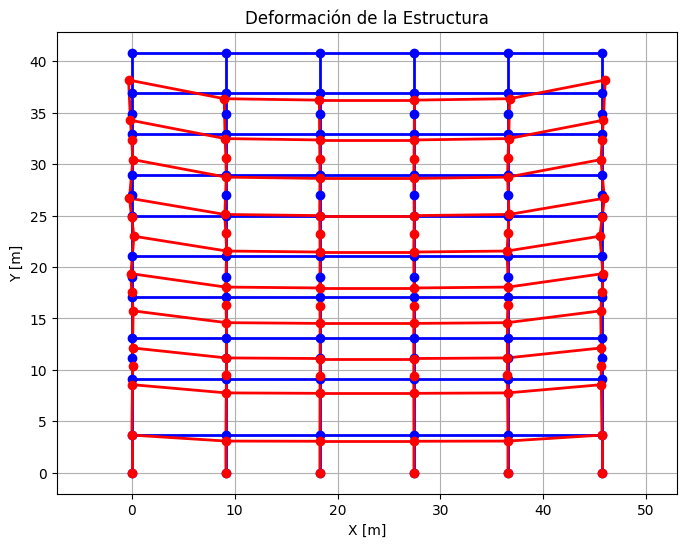

--------------------------------------------
Node 1 at [0. 0.]
Indices en matriz global: [0 1 2]
Carga nodal: [18.46164673  0.          0.        ]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 2 at [9.14 0.  ]
Indices en matriz global: [3 4 5]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 3 at [18.28  0.  ]
Indices en matriz global: [6 7 8]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 4 at [27.42  0.  ]
Indices en matriz global: [ 9 10 11]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 5 at [36.56  0.  ]
Indices en matriz global: [12 13 14]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
-----------

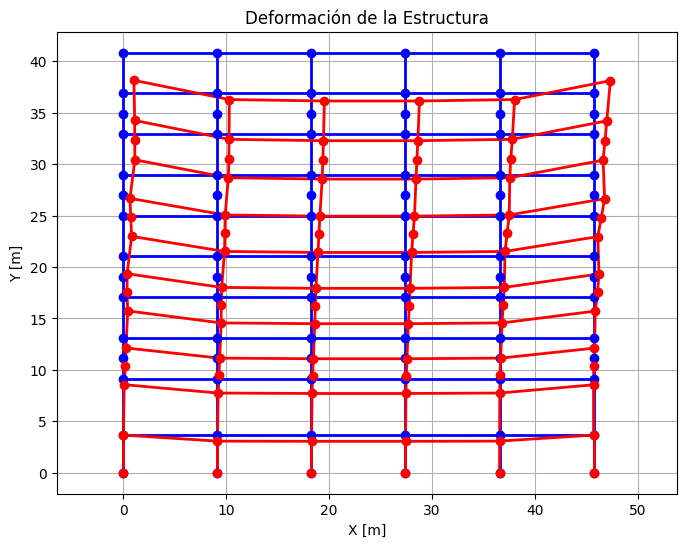

--------------------------------------------
Node 1 at [0. 0.]
Indices en matriz global: [0 1 2]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 2 at [9.14 0.  ]
Indices en matriz global: [3 4 5]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 3 at [18.28  0.  ]
Indices en matriz global: [6 7 8]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 4 at [27.42  0.  ]
Indices en matriz global: [ 9 10 11]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------------

--------------------------------------------
Node 5 at [36.56  0.  ]
Indices en matriz global: [12 13 14]
Carga nodal: [0. 0. 0.]
Restricciones: ['r' 'r' 'f']
--------------------------------------

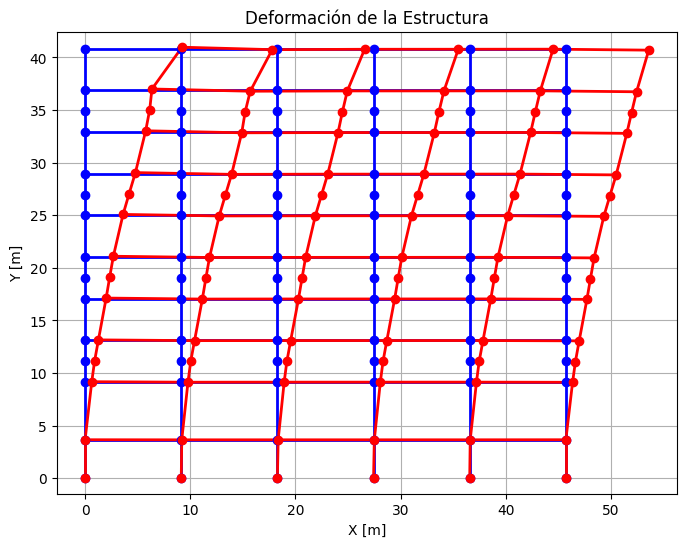

In [130]:

for caso in range(1, 4):
    
    nodos=crear_nodos(caso)
    elementos = crear_elementos(nodos,dx)
    nDoF_total = len(nodos) * globalParameters['nDoF']
    K_global = np.zeros((nDoF_total, nDoF_total))

    # Agregar cada elemento en la matriz global
    for elemento in elementos:
        dofs = np.hstack([elemento.node_i.idx, elemento.node_j.idx])
        for i in range(6):
            for j in range(6):
                K_global[dofs[i], dofs[j]] += elemento.k_global[i, j]

    solver = StructureSolver(nodos, K_global, globalParameters['nDoF'])

    # Obtener resultados
    desplazamientos = solver.get_displacements()
    reacciones = solver.get_reactions()

    # Mostrar resultados
    solver.resumen()
    fig, ax = plt.subplots(figsize=(8, 6))

    # Aplicar factor de escala a la deformación
    if caso != 3:
        scale_factor = 1000
    else:
        scale_factor = 10  # Ajusta este valor para visualizar mejor la deformación

    # Graficar las barras originales
    for elem in elementos:
        ax = elem.plotElement(ax=ax, color='b', text=False)

    # Graficar las barras deformadas
    plot_deformed_elements(elementos, ax=ax, scale_factor=scale_factor)

    # Graficar los nodos originales
    for nodo in nodos:
        ax.plot(nodo.coordenadas[0], nodo.coordenadas[1], 'bo')  # Nodos originales en azul

    # Graficar los nodos deformados
    for i, nodo in enumerate(nodos):
        # Aquí calculamos la deformación para cada nodo
        delta_x = desplazamientos[i * 3]  # Suponiendo que desplazamientos[i*3] es el desplazamiento en X
        delta_y = desplazamientos[i * 3 + 1]  # Suponiendo que desplazamientos[i*3+1] es el desplazamiento en Y
        
        # Calculamos la posición deformada (sin escala aún)
        nodo_deformado = nodo.coordenadas + np.array([delta_x, delta_y])

        # Aplicamos el factor de escala solo para la visualización
        nodo_deformado_scaled = nodo.coordenadas + np.array([delta_x, delta_y]) * scale_factor

        # Graficamos los nodos deformados en rojo
        ax.plot(nodo_deformado_scaled[0], nodo_deformado_scaled[1], 'ro')  # Nodos deformados en rojo

    ax.set_xlabel('X [m]')
    ax.set_ylabel('Y [m]')
    ax.set_title('Deformación de la Estructura')
    ax.grid(True)
    ax.axis('equal')
    plt.show()